In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from astropy import units as u
from astropy import constants as co
from astropy import coordinates
from astropy import cosmology
from astropy import table
from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfparse import query
from ekfphys import observer
from ekfphot import photometry as ep
#from carpenter import handler
from spatialsf import photometry
from SAGAbg import calibrations

import sep

from astropy import wcs

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 14

In [3]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
ugc_color = ec.ColorBase("#ff6421")
friend_color = ec.ColorBase("#a3d9af").evenly_spaced_colors(3)[1]

In [5]:
targetcoord = (146.030013, -0.658367)
friendcoord = (146.007801, -0.642259)
cz = 1500. * u.km/u.s
z = float((cz / co.c).decompose())
password = 'Db1xvXGcBKWkFIxPpLOPbbXlM8SxCFL4+jSFS8o1'

In [6]:
datadir = '../local_data/cutouts/'

In [7]:
#handler.fetch_hsc ( np.array([targetcoord]), datadir, half_size=(5.*u.arcmin).to(u.arcsec), hsc_passwd=password, filetype='coadd/bg' )

In [8]:
query.download_galeximages ( *targetcoord, name='galex_defaultformat', savedir=datadir )

Saved to: ../local_data/cutouts/mastDownload/GALEX/2411574383865757696


(0,
 <Table length=9>
                                            Local Path                                           ...
                                              str95                                              ...
 ----------------------------------------------------------------------------------------------- ...
 ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-fd-flags.fits.gz ...
  ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-fd-rrhr.fits.gz ...
 ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-fd-skybg.fits.gz ...
 ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-nd-flags.fits.gz ...
  ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-nd-rrhr.fits.gz ...
 ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1_24342_0266-nd-skybg.fits.gz ...
  ../local_data/cutouts/mastDownload/GALEX/2411574383865757696/MISDR1

In [9]:
cutouts = query.load_galexcutouts ( 'galex_defaultformat', datadir, coordinates.SkyCoord(*targetcoord, unit='deg'), 10.*u.arcmin, 10.*u.arcmin)

galex_defaultformat maps to MISDR1_24342_0266


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:265: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:265: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


galex_defaultformat maps to MISDR1_24342_0266


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:265: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:265: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


In [10]:
cutout_size = cutouts['fd'][0].shape

In [11]:
Av = query.get_SandFAV ( targetcoord[0], targetcoord[1] )

In [12]:
catalog, segmap = sep.extract ( 
    cutouts['fd'][0].data.byteswap().newbyteorder(),
    3., 
    err=cutouts['fd'][1].data.byteswap().newbyteorder()**.5, 
    segmentation_map=True
)
catalog = table.Table(catalog).to_pandas ()

In [13]:
ugcid = segmap[200,200]

In [14]:
friendid = segmap[240,250]

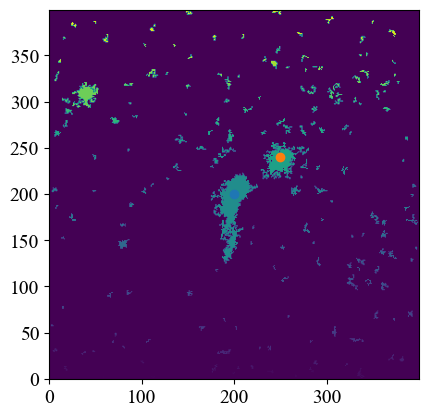

In [15]:
plt.imshow(segmap, origin='lower')
plt.scatter(200,200)
plt.scatter(250,240)

In [16]:
gi_target = ep.GalexImaging ( #ugcid, 
                       galex_bundle=cutouts, 
                       av=Av,
                       filter_directory='/Users/kadofong/work/surveys/literature_ref/filters/' )
esize = 3.
ugc_flux = gi_target.do_ephotometry ( 
    targetcoord,
    catalog.loc[ugcid-1],
    cat_pixscale=gi_target.wcs.get_pixscale ( 'NUV' ),    
    output_unit='Jy',
    ellipse_size=esize**2,
)
gi_friend = ep.GalexImaging ( #friendid, 
                       galex_bundle=cutouts, 
                       av=Av,
                       filter_directory='/Users/kadofong/work/surveys/literature_ref/filters/' )
friend_flux =gi_friend.do_ephotometry ( 
    friendcoord,
    catalog.loc[friendid-1],
    cat_pixscale=gi_friend.wcs.get_pixscale ( 'NUV' ),    
    output_unit='Jy',
    ellipse_size=esize**2
)

[GalexImaging] 10^(0.4*A_FUV) = 1.4681
[GalexImaging] 10^(0.4*A_NUV) = 1.4582
[GalexImaging] 10^(0.4*A_FUV) = 1.4681
[GalexImaging] 10^(0.4*A_NUV) = 1.4582


In [17]:
ugc_flux

array([[4.39985448e-04, 6.78803351e-04],
       [6.22931336e-06, 5.18829444e-06]])

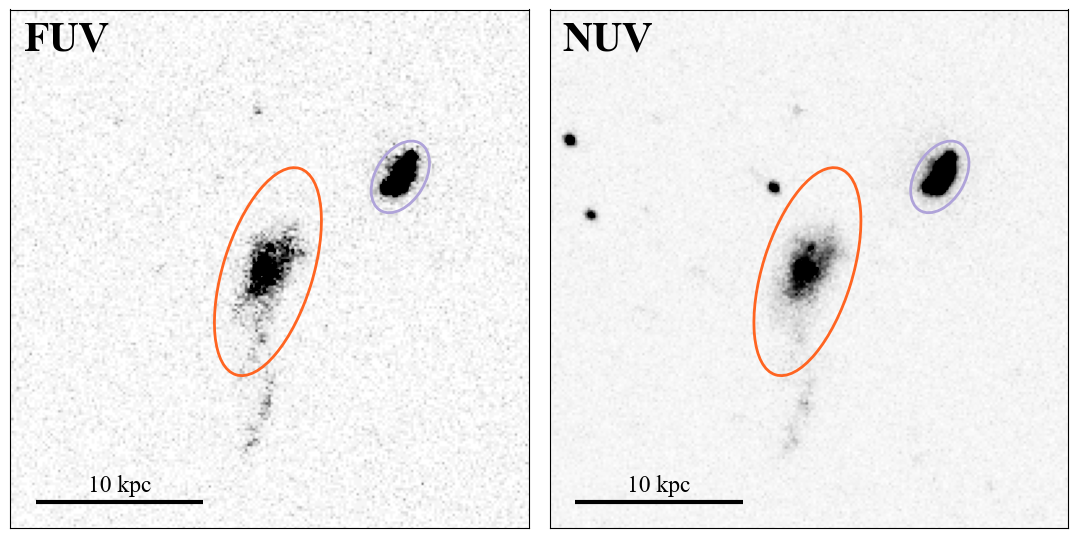

In [18]:
fig, axarr = plt.subplots(1,2,figsize=(11,6))

galex_labels = {'fd':'FUV','nd':"NUV"}
for key, ax in zip(['fd','nd'],axarr):
    clist = [ugc_color, friend_color]

    ek.imshow(cutouts[key][0].data, cmap='Greys', q=0.002,ax=ax)

    apertures = gi_target.emask + gi_friend.emask
    #ek.imshow_segmentationmap ( apertures, lw=2, color='lime' )

    for index,(gi,idx) in enumerate(zip([gi_target,gi_friend],[ugcid, friendid])):
        row = catalog.loc[idx-1]
        grow = np.sqrt(gi.emask.sum() / (np.pi*row['a']*row['b']))
        #print(grow)
        ap = patches.Ellipse ( (row['x'],row['y']), 2*row['a']*grow, 2*row['b']*grow, angle=np.rad2deg(row['theta']), 
                              facecolor='None', edgecolor=clist[index].base, lw=2 )
        ax.add_patch(ap)
    
    ek.text (
        0.025,
        0.975,
        galex_labels[key],
        fontsize=30,
        color='k',
        fontweight='bold',
        ax=ax
    )
    ax.set_xlim(100,300 )
    ax.set_ylim(100,300 )
    ax.set_xticks([])
    ax.set_yticks([]) 
    
    bar_lengthphys = 10. # kpc
    bar_lengthsky = np.rad2deg(bar_lengthphys/cosmo.angular_diameter_distance(z).to(u.kpc).value)*3600. # arcsec
    bar_lengthpix = bar_lengthsky / gi_target.pixscale # arcsec / pix
    ax.hlines ( 110, 110, 110+bar_lengthpix, lw=3, color='k' )
    ax.text ( 110 + bar_lengthpix/2, 112, '10 kpc', ha='center', va='bottom', fontsize=17 )
fig.tight_layout ()
plt.savefig('/Users/kadofong/work/papers/journal/UGC5205/FIG/galex.pdf')

In [19]:

factor = 1.0556261199156234e-28 # BPASS + 300 Myr constant SFR
#1.4e-28 # K98, Salpeter IMF

sfrUV_ugc = factor * (ugc_flux*u.Jy * (4.*np.pi*cosmo.luminosity_distance(z)**2)).to(u.erg/u.s/u.Hz).value
#sfrUV_ugc = 10.**calibrations.convert_imf ( np.log10(sfrUV_ugc), 'salpeter','kroupa' )
LFUV_friend = (friend_flux*u.Jy * (4.*np.pi*cosmo.luminosity_distance(z)**2)).to(u.erg/u.s/u.Hz)
sfrUV_friend = factor * (friend_flux*u.Jy * (4.*np.pi*cosmo.luminosity_distance(z)**2)).to(u.erg/u.s/u.Hz).value
#sfrUV_friend = 10.**calibrations.convert_imf ( np.log10(sfrUV_friend), 'salpeter','kroupa' )


In [20]:
nrow,ncol = cutouts['fd'][0].data.shape
ra_pix, _ = gi_target.wcs.FUV.all_pix2world ( np.arange(nrow), np.zeros(nrow), 1 )
_, dec_pix = gi_target.wcs.FUV.all_pix2world ( np.ones(ncol), np.arange(ncol), 1 )

In [21]:
row = catalog.loc[ugcid-1]

# Ha SFRs

In [22]:
from astropy.io import fits
import emcee

In [23]:
def setup_run ( wave, flux, cl, stddev_em_init, stddev_abs_init, EW_init, p0_std, nwalkers, allow_lww=False ):
    # \\ initialize walkers
    ainit = np.zeros(cl.n_emission)
    balmer_lr = dict(zip(['Hbeta','Hgamma','Hdelta'],[2.86, 6.11,11.06]))
    oiii_lr = dict(zip(['[OIII]4959', '[OIII]4363'],[2.98, 6.25]))
    for idx,key in enumerate(cl.emission_lines.keys()):
        if key in balmer_lr.keys():
            ainit[idx] = ainit[list(cl.emission_lines.keys()).index("Halpha")] / (balmer_lr[key]*1.25)
        elif key in oiii_lr.keys():
            ainit[idx] = ainit[list(cl.emission_lines.keys()).index("[OIII]5007")] / (oiii_lr[key]*1.25)
        else:
            inline,_=line_fitting.get_lineblocs(wave,z=cl.z, lines=cl.emission_lines[key])
            ainit[idx] = np.nanmax(flux[inline])                
        
    cinit = np.zeros(cl.n_continuum)
    for idx,key in enumerate(cl.continuum_windows.keys()):
        _,inbloc=line_fitting.get_lineblocs(wave,z=cl.z, lines=cl.continuum_windows[key])
        cinit[idx] = np.nanmedian(flux[inbloc])
    cinit[cinit<0.] = 1e-5
    print (f'[do_bayesianfitlines] Amplitude init: {ainit}')
    print (f'[do_bayesianfitlines] Continuum init: {cinit}')
    
    winit = np.random.uniform ( -0.1, 0.1, ainit.size ) # initialize wiggles on line center and line width
    if allow_lww:
        p0 = np.concatenate([ainit, winit, winit, cinit, np.array([EW_init, stddev_em_init, stddev_abs_init])])
    else:
        p0 = np.concatenate([ainit, winit, cinit, np.array([EW_init, stddev_em_init, stddev_abs_init])])
        
    p0 = p0[np.newaxis,:]
    p_init = np.random.normal(p0, p0_std*abs(p0), [nwalkers, p0.size])
    
    # \\ add in our physical line constraints    
    for idx,key in enumerate(cl.emission_lines.keys()):
        if key == '[SII]6717':
            p_init[:,idx] = p_init[:,list(cl.emission_lines.keys()).index("[SII]6731")]*np.random.uniform(.67, 2.22, p_init.shape[0])
        elif key == '[OII]7330':            
            p_init[:,idx] = p_init[:,list(cl.emission_lines.keys()).index("[OII]7320")]*np.random.uniform(0.8, .81, p_init.shape[0])
        elif key == '[NII]6583':
            p_init[:,idx] = p_init[:,list(cl.emission_lines.keys()).index("[NII]6548")]*np.random.uniform(2.9, 3., p_init.shape[0])
            
    return p_init

In [24]:
from SAGAbg import line_fitting, line_db, models

In [25]:
companion_spec = fits.open('../local_data/companion_spectra/spec-0266-51630-0100.fits')

In [26]:
central_spec = fits.open('../local_data/sdss_spectra/spec-0266-51630-0095.fits')

In [27]:
wave = 10.**companion_spec[1].data['loglam'].astype(float)
flux_raw = companion_spec[1].data['flux'].astype(float)
flux = flux_raw * observer.gecorrection ( wave, Av ) # correct for galactic extinction
var = companion_spec[1].data['ivar'].astype(float)


In [28]:
lines = line_db.halpha_only
#lines['Hbeta'] = line_db.hbeta_only['Hbeta']
cl = models.CoordinatedLines ( z=z,
                               emission_lines=lines, 
                               absorption_lines=None, #dict([ (key, lines[key]) for key in line_db.BALMER_ABSORPTION if key in lines.keys() ]), 
                               continuum_windows=None,#dict([ (key, lines[key]) for key in line_db.CONTINUUM_TAGS if key in lines.keys() ]),
                               allow_lww=False,
                             ) 
cl_hb = models.CoordinatedLines ( z=z,
                               emission_lines=line_db.hbeta_only, 
                               absorption_lines=None, #dict([ (key, lines[key]) for key in line_db.BALMER_ABSORPTION if key in lines.keys() ]), 
                               continuum_windows=None,#dict([ (key, lines[key]) for key in line_db.CONTINUUM_TAGS if key in lines.keys() ]),
                               allow_lww=False,
                                 window_width = 100.
                             ) 
u_flux = np.sqrt(cl.construct_specflux_uncertainties ( wave, flux )**2 + var)

In [29]:
nwalkers = 32

p_init = setup_run ( wave, flux, cl, 2., 2., -1., 0.1, nwalkers, False )
p_init_hb = setup_run ( wave, flux, cl_hb, 2., 2., -1., 0.1, nwalkers, False )

#p_init[:,1] = np.random.normal(10., 3., nwalkers)
#p_init[:,2] = np.random.normal(40., 3., nwalkers)

[do_bayesianfitlines] Amplitude init: [6649.17648366   42.84285835   88.84275958]
[do_bayesianfitlines] Continuum init: [18.94588966]
[do_bayesianfitlines] Amplitude init: [6649.17648366 1859.90950592   42.84285835   88.84275958]
[do_bayesianfitlines] Continuum init: [18.94588966 30.1676852 ]


In [30]:
espec = models.EmceeSpec ( cl, wave, flux, u_flux, lsigma_min=0.5, lsigma_max=20.,  
                          ew_abs_min=-2.1, wiggle_max=10., ignore_physics=True)
sampler = emcee.EnsembleSampler ( nwalkers, p_init.shape[1], espec.log_prob, )



In [31]:
espec_hb = models.EmceeSpec ( cl_hb, wave, flux, u_flux, lsigma_min=0.5, lsigma_max=5.,  
                             ew_abs_min=-2.1, wiggle_max=10., ignore_physics=True)
sampler_hb = emcee.EnsembleSampler ( nwalkers, p_init_hb.shape[1], espec_hb.log_prob, )

#### MCMC

In [32]:
out = sampler.run_mcmc ( p_init, 2000, progress=True )


100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 327.24it/s]


In [33]:
out_hb = sampler_hb.run_mcmc ( p_init_hb, 2000, progress=True )

100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 271.94it/s]


In [34]:
chain = sampler.get_chain()

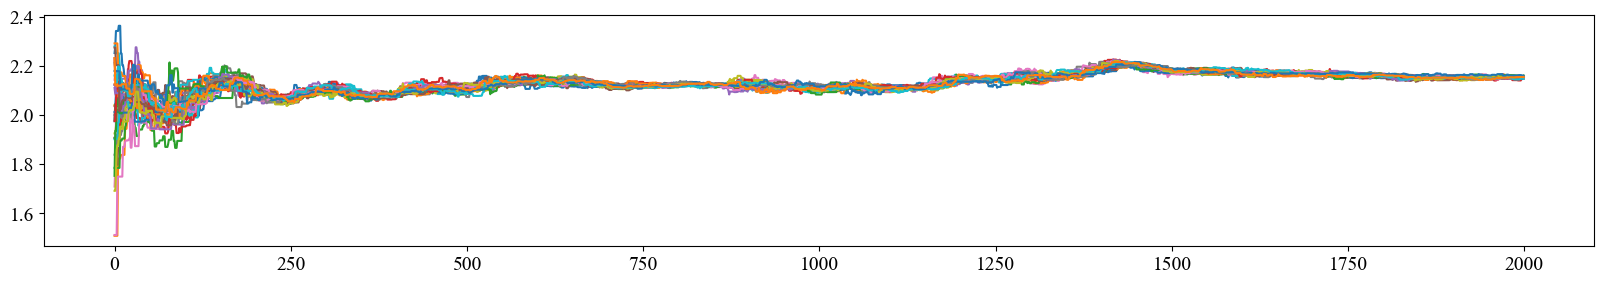

In [35]:
fig = plt.figure(figsize=(20,3))
for idx in range(nwalkers):
    plt.plot ( chain[:,idx,-2] )

In [36]:
discard = 1500
fchain = sampler.get_chain(discard=discard,flat=True)
targs = np.nanmedian(fchain,axis=0)
cl.set_arguments(targs)
ox = espec.log_prob(targs)
#targs[cl.get_line_index('Halpha','continuum')] = 15.
#cl.set_arguments(targs)
#nx = espec.log_prob(targs)
#nx>ox

Text(0, 0.5, 'flux (relative?)')

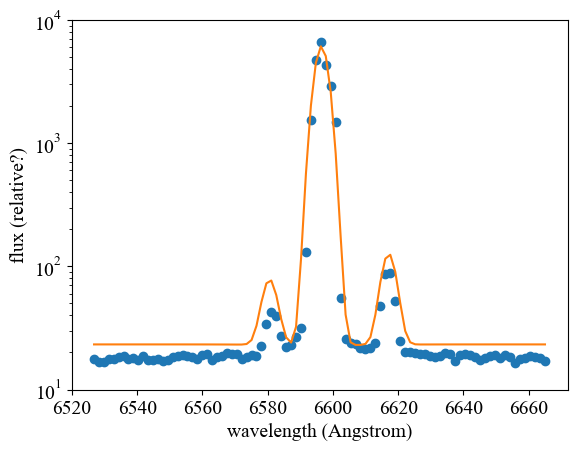

In [37]:
line_bloc, window_bloc = models.get_lineblocs ( wave, z=cl.z, lines=cl.emission_lines['Halpha'] )
plt.plot(wave[window_bloc], flux[window_bloc], 'o', label='data')
plt.plot ( wave[window_bloc], cl.evaluate(wave)[window_bloc], label='model')
hwv =(1.+cl.z)*cl.emission_lines['Halpha']
#plt.xlim(hwv-300., hwv+300.)
plt.yscale('log')
plt.ylim(10.,1e4)
plt.xlabel('wavelength (Angstrom)')
plt.ylabel('flux (relative?)')

In [38]:
fchain_hb = sampler_hb.get_chain(discard=discard,flat=True)
targs_hb = np.nanmedian(fchain_hb,axis=0)
cl_hb.set_arguments(targs_hb)


Text(0, 0.5, 'flux (relative?)')

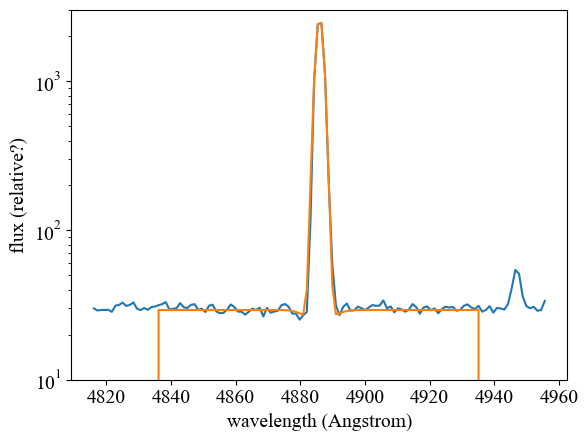

In [39]:
line_bloc, window_bloc = models.get_lineblocs ( wave, z=cl.z, lines=cl_hb.emission_lines['Hbeta'] )
plt.plot(wave[window_bloc], flux[window_bloc], label='data')
plt.plot ( wave[window_bloc], cl_hb.evaluate(wave)[window_bloc], label='model')

plt.yscale('log')
plt.ylim(10.,3e3)
plt.xlabel('wavelength (Angstrom)')
plt.ylabel('flux (relative?)')

In [40]:
hbeta_flux = models.get_linefluxes(fchain_hb, cl_hb.n_emission)[:,cl_hb.get_line_index ('Hbeta', 'emission' )]

In [41]:
halpha_flux = models.get_linefluxes(fchain, cl.n_emission)[:,0]
halpha_fc = fchain[:,cl.get_line_index ( 'Halpha', 'continuum' )]
halpha_ew = halpha_flux/halpha_fc

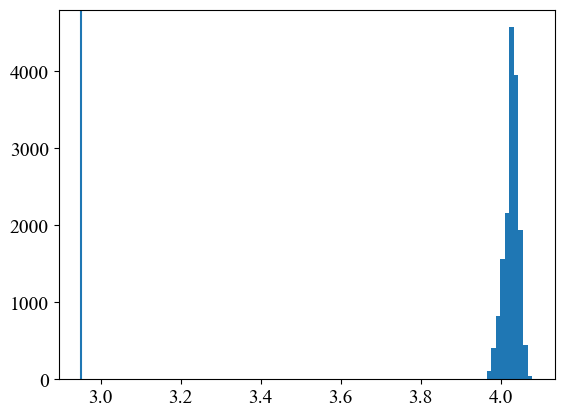

In [42]:
plt.hist(halpha_flux/hbeta_flux)
plt.axvline ( 10.**0.47 )

In [43]:
nii6548_flux = models.get_linefluxes (fchain, cl.n_emission)[:,cl.get_line_index('[NII]6548')]
nii6583_flux = models.get_linefluxes (fchain, cl.n_emission)[:,cl.get_line_index('[NII]6583')]

Text(0, 0.5, 'PDF')

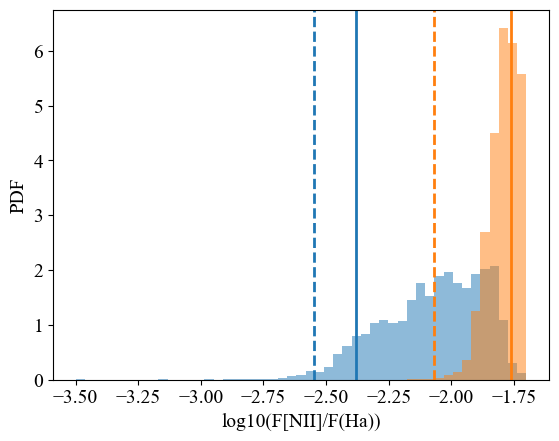

In [44]:
bins = np.linspace(-3.5,-1.7,50)
plt.hist(np.log10(nii6548_flux/halpha_flux), bins=bins, color='C0', alpha=0.5, density=True)
plt.hist(np.log10(nii6583_flux/halpha_flux), bins=bins, color='C1', alpha=0.5, density=True)
plt.axvline (-2.55, lw=2, color='C0', ls='--')
plt.axvline (-2.38, lw=2, color='C0')
plt.axvline ( -2.07, lw=2, color='C1', ls='--')
plt.axvline ( -1.76, lw=2, color='C1')
plt.xlabel ( 'log10(F[NII]/F(Ha))' )
plt.ylabel( 'PDF')

1425.2538000092095
[ 471.92538332 -500.91371463]
[ 0.33111673 -0.3514558 ]


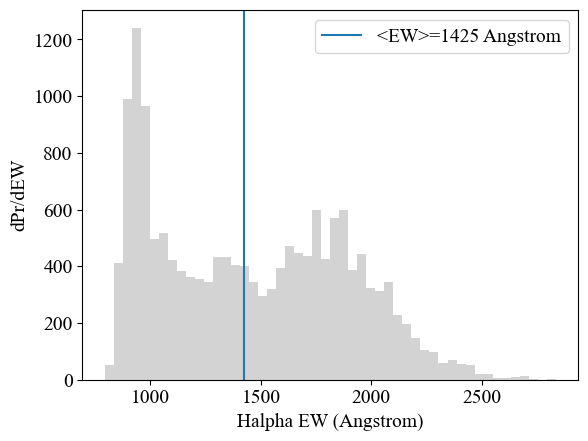

In [45]:
plt.hist(halpha_ew, bins=50, color='lightgrey')
medha = np.median(halpha_ew)
plt.axvline(medha, label=r'<EW>=%i Angstrom' % np.median(halpha_ew))
print( medha )
dew = medha- np.quantile ( halpha_ew, [0.16,.84]) 
print( dew )
print ( dew/medha )
plt.xlabel('Halpha EW (Angstrom)')
plt.ylabel('dPr/dEW')
plt.legend ()

### UGC

In [56]:
#lines['Hbeta'] = line_db.hbeta_only['Hbeta']
cl_ugc = models.CoordinatedLines ( z=((1500.*u.km/u.s)/co.c).decompose(),
                               emission_lines=line_db.balmer_only,
                               absorption_lines=None, #dict([ (key, lines[key]) for key in line_db.BALMER_ABSORPTION if key in lines.keys() ]), 
                               continuum_windows=None,#dict([ (key, lines[key]) for key in line_db.CONTINUUM_TAGS if key in lines.keys() ]),
                               allow_lww=False,
                             ) 

In [57]:
wave = 10.**central_spec[1].data['loglam'].astype(float)
flux_raw = central_spec[1].data['flux'].astype(float)
flux = flux_raw * observer.gecorrection ( wave, Av ) # correct for galactic extinction
var = central_spec[1].data['ivar'].astype(float)**-1.
is_finite = np.isfinite(flux)
wave = wave[is_finite]
flux = flux[is_finite]
var = var[is_finite]

nwalkers = 64
p_init = setup_run ( wave, flux, cl_ugc, 2., 2., -1., 0.1, nwalkers, False )

[do_bayesianfitlines] Amplitude init: [7.30581604 2.04358491 0.95657166 0.52844962 7.88115853 7.38075038]
[do_bayesianfitlines] Continuum init: [ 6.89094276 11.72331803 14.2041975  16.23862483]


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_16682/3069783790.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  var = central_spec[1].data['ivar'].astype(float)**-1.


In [58]:
u_flux = np.sqrt(cl_ugc.construct_specflux_uncertainties ( wave, flux )**2 + var)
espec = models.EmceeSpec ( cl_ugc, wave, flux, u_flux, lsigma_min=0.5, lsigma_max=20.,  
                          ew_abs_min=-30., wiggle_max=10., ignore_physics=False)
sampler = emcee.EnsembleSampler ( nwalkers, p_init.shape[1], espec.log_prob, )

out = sampler.run_mcmc ( p_init, 2000, progress=True )


  1%|▎                                        | 18/2000 [00:01<02:11, 15.03it/s]/Users/kadofong/work/projects/SAGAbg/python/SAGAbg/models.py:479: RuntimeWarning: divide by zero encountered in log
  lp += np.log(gaussian(nii_lr, (np.sqrt(2.*np.pi) * (0.1*nii_doublet)**2)**-1, nii_doublet,  (0.1*nii_doublet)**2 ))
100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.80it/s]


In [59]:
fchain = sampler.get_chain(discard=discard,flat=True)

targs = np.nanmedian(fchain,axis=0)
cl_ugc.set_arguments(targs)

ugc_halpha_flux = models.get_linefluxes(fchain, cl.n_emission)[:,0]
ugc_halpha_fc = fchain[:,cl_ugc.get_line_index ( 'Halpha', 'continuum' )]
ugc_halpha_abs = fchain[:,-3]*.5
ugc_halpha_ew = ugc_halpha_flux/ugc_halpha_fc

NameError: name 'bl' is not defined

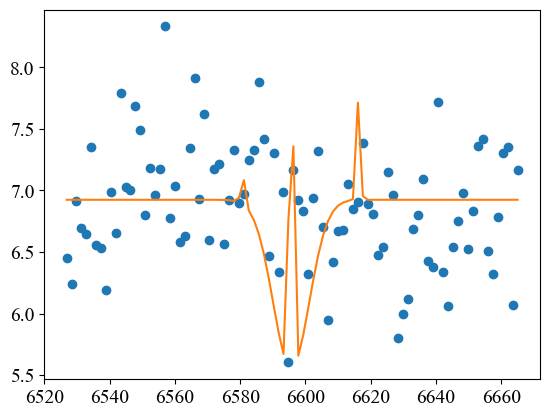

In [62]:
line = "Halpha"
line_bloc, window_bloc = models.get_lineblocs ( wave, z=cl_ugc.z, lines=cl_ugc.emission_lines[line] )
plt.plot(wave[window_bloc], flux[window_bloc], 'o', label='data')
plt.plot ( wave[window_bloc], cl_ugc.evaluate(wave)[window_bloc], label='model')
hwv =(1.+cl_ugc.z)*cl_ugc.emission_lines[line]
plt.axhline ( np.median(halpha_fc) + bl )
#plt.xlim(hwv-300., hwv+300.)
#plt.yscale('log')
#plt.ylim(10.,1e4)
plt.xlabel('wavelength (Angstrom)')
plt.ylabel('flux (relative?)')

In [88]:
bl = flux[window_bloc].std()*5.
ugc_haew = bl/np.median(ugc_halpha_fc) + abs(np.quantile(ugc_halpha_abs,0.5))
ugc_haew_nocorr = bl/np.median(ugc_halpha_fc)

#### overflow issue because u_flux was too small/line too strong(?)

In [67]:
espec.log_prob ( p_init[:,1] )

-inf

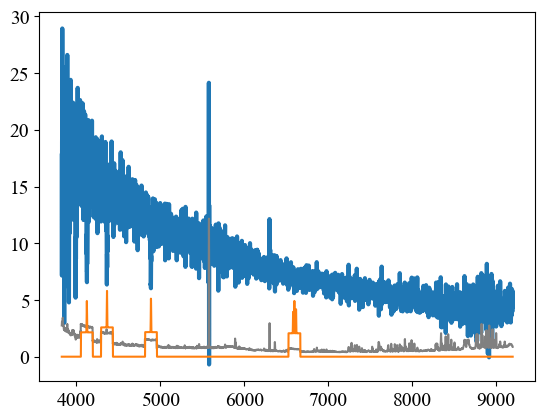

In [68]:
plt.plot (wave, flux, lw=3)
plt.plot ( wave, u_flux, color='grey')
plt.plot (wave, espec.model.evaluate(wave))

In [47]:
residsq = (espec.model.evaluate ( espec.wave )  -  espec.flux)**2                
inner = -0.5*np.sum(residsq / espec.u_flux**2 + np.log(2.*np.pi*espec.u_flux**2) )    


In [48]:
residsq / espec.u_flux**2

array([17898.58232647, 20593.63137897, 21890.64085956, ...,
         118.75276868,   103.53831827,    47.29211841])

In [49]:
np.sum(residsq / espec.u_flux**2)

6539522496446.594

In [50]:
np.sum(residsq / espec.u_flux**2 + np.log(2.*np.pi*espec.u_flux**2))

6539522503143.209

In [51]:
inner

-3269761251571.6045

In [52]:
espec.log_likelihood ()

-348986.98758209817

# Halpha SFR estimates from EW

In [69]:
import os
from astropy import units as u
from astropy import constants as co
from SAGAbg import calibrations

In [70]:
friend_haew = halpha_ew
#ugc_haew = 0.5

In [71]:
# \\ Need absolute r-band magnitudes
nsa = table.Table(fits.getdata(f'{os.environ["HOME"]}/work/surveys/literature_ref/NSA/nsa_v0_1_2.fits',1))
nsa.add_index('NSAID')

In [72]:
littleh = float(cosmo.H0 / (100. * u.km/u.s/u.Mpc))
ugc_Mr = nsa.loc[136055]['ABSMAG'][4]  + 5.*np.log10(littleh)
friend_Mr = nsa.loc[7]['ABSMAG'][4] + 5.*np.log10(littleh)

In [73]:
ugc_Mr

-17.013395679445317

In [74]:
def LHa ( haew, Mr, fhafhb=3. ):
    constant = (3e18*u.W).to(u.erg/u.s).value / (6563.*(1.+z))**2
    t0 = 10.**(-0.4*(Mr-34.1))
    t1 = (fhafhb/2.86)**2.36
    return constant * haew * t0 * t1

In [75]:
ab = 2.59e-13 * u.cm**3 * u.s**-1 # case B recombination coefficient at 10^4 K, 10^3 cm^-3
aeff = 1.17e-13 * u.cm**3 * u.s**-1 # same for Halpha
halpha_energy = (co.h*co.c/(6563.*u.AA)).to(u.erg)

In [76]:
QH_friend = LHa(friend_haew, friend_Mr, 4.)*u.erg/u.s / halpha_energy * ab/aeff

In [89]:
hafactor = 5.0314587562590027e-42
sfrha_ugc = hafactor * LHa(ugc_haew, ugc_Mr, 4.)
sfrha_ugc_nocorr = hafactor * LHa(ugc_haew_nocorr, ugc_Mr, 4.)

sfrha_friend = hafactor * LHa(friend_haew, friend_Mr, 4.)
#sfrha_ugc = 10.**calibrations.convert_imf(np.log10(calibrations.LHa2SFR_K98(LHa(ugc_haew, ugc_Mr))),'salpeter','kroupa')
#sfrha_friend = 10.**calibrations.convert_imf(np.log10(calibrations.LHa2SFR_K98(LHa(friend_haew, friend_Mr))),'salpeter','kroupa')

print( sfrha_ugc )
print ( np.median(sfrha_friend) )

0.006631966467256185
3.0528500938579577


In [78]:
friend_Mr

-17.016750705690434

In [79]:
 LHa( 10., -18., 4.)

1.0529774543151576e+40

# SFMS figure

In [80]:
import pandas as pd
from ekfplot import colors as ec

In [81]:
properties = pd.read_csv("../local_data/table1.csv", index_col=0)

In [82]:
dale = table.Table.read('../../../literature_ref/dale2023/table5.dat', format='cds')
dale['logmstar_kroupa'] = calibrations.convert_imf( dale['logM*'], 'chabrier' )
dale['logsfr_kroupa'] = calibrations.convert_imf( dale['logSFR100'], 'chabrier' )

In [121]:
ugc_haew

3.105782656247051

In [122]:
ugc_haew_nocorr

0.3525784396763668

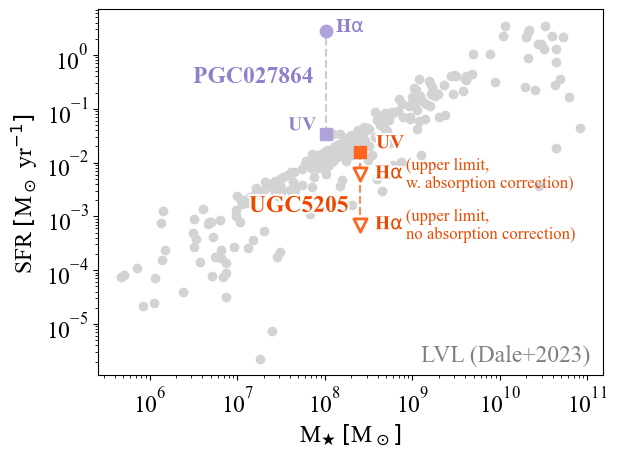

In [120]:
ugc_logmstar = 1e8*properties.loc['UGC5205','logmstar']
plot_ugc_sfrUV = 10.**calibrations.convert_imf(np.log10(sfrUV_ugc[0,0]), 'salpeter')
plot_ugc_sfrHa = 10.**calibrations.convert_imf(np.log10(sfrha_ugc), 'chabrier')
plot_ugc_sfrHa_nocorr = 10.**calibrations.convert_imf(np.log10(sfrha_ugc_nocorr), 'chabrier')

friend_logmstar = 1e8*properties.loc['MCG+00-25-010','logmstar']
plot_friend_sfrUV = 10.**calibrations.convert_imf(np.log10(sfrUV_friend[0,0]), 'salpeter')
plot_friend_sfrHa = 10.**calibrations.convert_imf(np.log10(np.median(sfrha_friend)), 'chabrier')

with plt.rc_context({'font.size':17}):
    fig = plt.figure ()

    plt.scatter ( 10.**dale['logmstar_kroupa'], 10.**dale['logsfr_kroupa'],                 
                  color='lightgrey', zorder=0 )

    # \\ UGC5205
    kwargs = {'color':ugc_color.base, 's':80}
    plt.scatter ( ugc_logmstar, plot_ugc_sfrUV, marker='s', **kwargs ) 
    plt.scatter ( ugc_logmstar, plot_ugc_sfrHa, 
                  marker='v', s=90, facecolor="w",
                  edgecolor=ugc_color.base, lw=2) 
    plt.scatter ( ugc_logmstar, plot_ugc_sfrHa_nocorr, 
                  marker='v', s=90, facecolor="w",
                  edgecolor=ugc_color.base, lw=2)     
    plt.vlines ( 
        ugc_logmstar,
        plot_ugc_sfrUV, 
        plot_ugc_sfrHa,
        color=ugc_color.modulate(0.1).base,
        ls='--',
        zorder=0
    )
    plt.vlines ( 
        ugc_logmstar,
        plot_ugc_sfrHa, 
        plot_ugc_sfrHa_nocorr,
        color=ugc_color.modulate(0.1).base,
        ls='--',
        zorder=0
    )

    # \\ Friend
    kwargs = {'color':friend_color.base, 's':80}
    plt.scatter ( friend_logmstar, plot_friend_sfrUV, marker='s', **kwargs ) 
    plt.scatter ( friend_logmstar, plot_friend_sfrHa, **kwargs) 
    plt.vlines ( 
        friend_logmstar,
        plot_friend_sfrUV, 
        plot_friend_sfrHa,
        color=friend_color.modulate(0.1).base,
        ls='--',
        zorder=0
    )

    ek.text ( ugc_logmstar, 10.**(0.5*(np.log10(plot_ugc_sfrHa) + np.log10(plot_ugc_sfrUV)))*.1,               
              'UGC5205  ', color=ugc_color.modulate(-0.1).base, fontweight='bold', ha='right', coord_type='absolute', bordercolor='w', borderwidth=3,)
    ek.text ( ugc_logmstar*10.**0.5, plot_ugc_sfrUV, 'UV', color=ugc_color.modulate(-0.1).base, fontsize=14, 
              bordercolor='w', borderwidth=3, fontweight='bold', coord_type='absolute' )
    ek.text ( ugc_logmstar*10.**0.5, plot_ugc_sfrHa, r'  H$\rm \alpha$', bordercolor='w', borderwidth=3, coord_type='absolute', 
              color=ugc_color.modulate(-0.1).base, fontsize=14, fontweight='bold', va='center'  )
    plt.text ( ugc_logmstar*3.3, plot_ugc_sfrHa, '''(upper limit, 
w. absorption correction)''',
              color=ugc_color.modulate(-0.1).base, fontsize=12,  ha='left', va='center' )
    ek.text ( ugc_logmstar*10.**0.5, plot_ugc_sfrHa_nocorr, r'  H$\rm \alpha$', bordercolor='w', borderwidth=3, coord_type='absolute', 
              color=ugc_color.modulate(-0.1).base, fontsize=14, fontweight='bold', va='center',  )
    plt.text ( ugc_logmstar*3.3, plot_ugc_sfrHa_nocorr, '''(upper limit, 
no absorption correction)''',
              color=ugc_color.modulate(-0.1).base, fontsize=12, ha='left', va='center' )    
    plt.text ( friend_logmstar, 10.**(0.5*(np.log10(plot_friend_sfrHa) + np.log10(plot_friend_sfrUV))), 
              'PGC027864  ', ha='right', 
               color=friend_color.modulate(-0.1).base, fontweight='bold' )
    ek.text ( friend_logmstar, plot_friend_sfrUV, 'UV  ', 
               color=friend_color.modulate(-0.1).base, fontsize=14, fontweight='bold', 
             bordercolor='w', borderwidth=2,  coord_type='absolute')
    plt.text ( friend_logmstar, plot_friend_sfrHa, r'  H$\rm \alpha$', color=friend_color.modulate(-0.1).base, fontsize=14,
               fontweight='bold')    

    ek.text ( 0.975, 0.025, 'LVL (Dale+2023)', color='grey' )

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'M$_\bigstar$ $[$M$_\odot]$')
    plt.ylabel(r'SFR $[$M$_\odot\ $yr$^{-1}]$')
plt.tight_layout ()
plt.savefig("/Users/kadofong/work/papers/journal/UGC5205/FIG/SFMS.pdf")

0.025715886703890845